In [ ]:
! git clone https://github.com/tejaslambat03/ImageRetouching.git
%cd ./ImageRetouching

fatal: destination path 'ImageRetouching' already exists and is not an empty directory.
/content/ImageRetouching


## Select a checkpoint

In [ ]:
task = "Dehazing_Outdoor"  # @param ["Dehazing_Indoor", "Dehazing_Outdoor", "Deraining", "Enhancement", "Retouching"]

model_handle_map = {
    "Dehazing_Indoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-indoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/1444_10.png",
    ],
    "Dehazing_Outdoor": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Dehazing/input/0003_0.8_0.2.png",
    ],
    "Deraining": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_deraining_raindrop/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Deraining/input/15.png",
    ],
    "Enhancement": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_lol/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
    "Retouching": [
        "https://tfhub.dev/sayakpaul/maxim_s-2_enhancement_fivek/1",
        "https://github.com/google-research/maxim/raw/main/maxim/images/Enhancement/input/a4541-DSC_0040-2.png",
    ],
}

model_handle = model_handle_map[task]
ckpt = model_handle[0]
print(f"TF-Hub handle: {ckpt}.")

TF-Hub handle: https://tfhub.dev/sayakpaul/maxim_s-2_dehazing_sots-outdoor/1.


## Imports

In [ ]:
!pip install einops

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

from PIL import Image
import numpy as np

In [ ]:
import sys

sys.path.append("..")

from create_maxim_model import Model
from maxim.configs import MAXIM_CONFIGS

TODO: When the repository is public, clone it and use accordingly.

## Fetch the input image based on the task

In [ ]:
from google.colab import files
from PIL import Image
import io
import os

# Function to handle file upload
def handle_uploaded_file(upload):
    # Get the first file uploaded
    uploaded_filename = next(iter(upload))
    # Get the content of the uploaded file
    image_content = upload[uploaded_filename]
    # Create a file-like object
    image_file = io.BytesIO(image_content)
    # Open the image
    image = Image.open(image_file)
    # Display the uploaded image
    image.show()
    # Get a unique filename
    image_path = os.path.join("/content", uploaded_filename)
    # Save the image
    image.save(image_path)
    # Return the path of the saved image
    return image_path

# Create a file upload button
upload_button = files.upload()

# Handle the uploaded file
if upload_button:
    image_path = handle_uploaded_file(upload_button)
    print("Image saved at:", image_path)


Saving Hazed-input-image-and-dehazed-output-image.png to Hazed-input-image-and-dehazed-output-image (8).png
Image saved at: /content/Hazed-input-image-and-dehazed-output-image (8).png


In [ ]:
#image_url = model_handle[1]
#image_path = tf.keras.utils.get_file(origin=image_url)
#Image.open(image_path)

## Load the model

In [ ]:
_MODEL = hub.load(ckpt)

## Preprocessing utilities



In [ ]:
def resize_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes `target_dim`.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image


def process_image(image_path, target_dim=256):
    input_img = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
    input_img = tf.expand_dims(input_img, axis=0)
    input_img = resize_image(input_img, target_dim)
    return input_img

## Run predictions

In [ ]:
def get_model(model_url: str, input_resolution: tuple) -> tf.keras.Model:
    inputs = tf.keras.Input((*input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)

    outputs = hub_module(inputs)

    return tf.keras.Model(inputs, outputs)


# Based on https://github.com/google-research/maxim/blob/main/maxim/run_eval.py
def infer(image_path: str, model: tf.keras.Model, input_resolution=(256, 256)):
    preprocessed_image = process_image(image_path, input_resolution[0])

    preds = model.predict(preprocessed_image)
    if isinstance(preds, list):
        preds = preds[-1]
        if isinstance(preds, list):
            preds = preds[-1]

    preds = np.array(preds[0], np.float32)
    final_pred_image = np.array((np.clip(preds, 0.0, 1.0)).astype(np.float32))
    return final_pred_image

In [ ]:
input_resolution = (256, 256)

model = get_model(ckpt, input_resolution)

final_pred_image = infer(image_path, model, input_resolution)

1/1 [==============================] - 29s 29s/step


## Visualize results

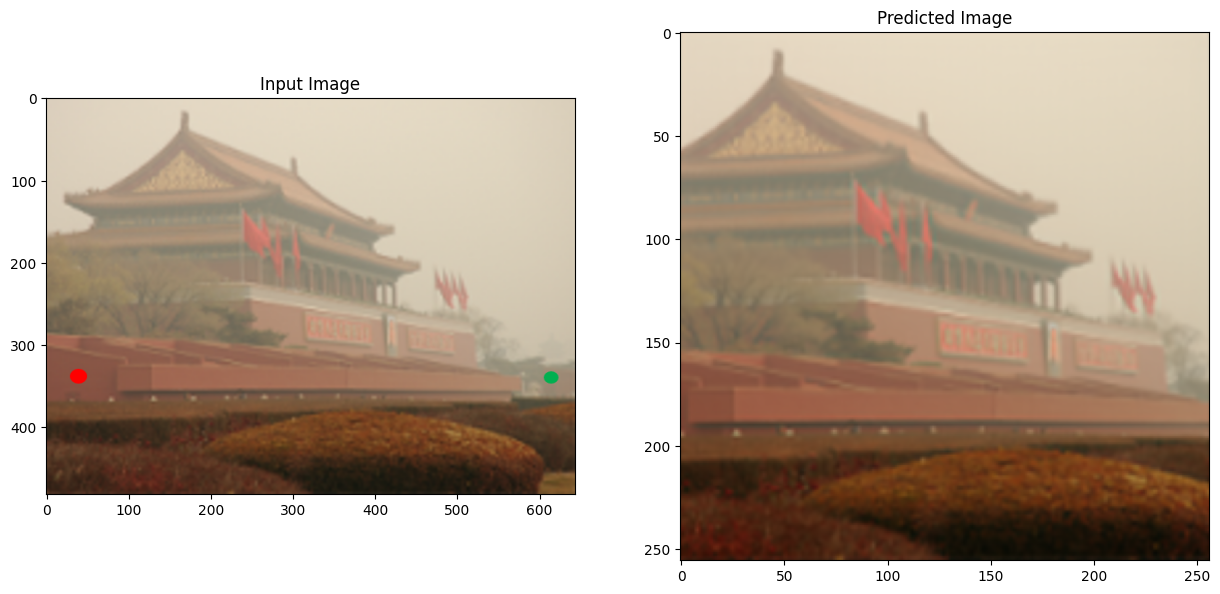

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)


plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
input_image = np.asarray(Image.open(image_path).convert("RGB"), np.float32) / 255.0
imshow(input_image, "Input Image")

plt.subplot(1, 2, 2)
imshow(final_pred_image, "Predicted Image")